In [3]:
import os
import cv2
import pandas as pd
import h5py
import numpy as np
from PIL import Image
import shutil
import matplotlib.pyplot as plt
from hypersim_util import dist_2_depth, tone_map

In [4]:
!pwd

/home/gustavo/workstation/depth_inpainting/data/ml-hypersim


In [5]:
save_path = "/home/gustavo/workstation/depth_inpainting/data/Hypersim/train"
save_path_h5 = "/home/gustavo/workstation/depth_inpainting/data/Hypersimh5/"
save_path_test = "/home/gustavo/workstation/depth_inpainting/data/Hypersim/test"
folder_path = "/home/gustavo/workstation/depth_inpainting/data/ml-hypersim/contrib/99991/downloads"
split_csv_path = "/home/gustavo/workstation/depth_inpainting/data/ml-hypersim/evermotion_dataset/analysis/metadata_images_split_scene_v1.csv"
base_path = "/home/gustavo/workstation/depth_inpainting/data/Hypersim"

In [6]:
df = pd.read_csv(split_csv_path)

In [7]:
df.head()

,scene_name,camera_name,frame_id,included_in_public_release,exclude_reason,split_partition_name
0,ai_001_001,cam_00,0,True,NaN,train
1,ai_001_001,cam_00,1,True,NaN,train
2,ai_001_001,cam_00,2,True,NaN,train
3,ai_001_001,cam_00,3,True,NaN,train
4,ai_001_001,cam_00,4,True,NaN,train


In [8]:
df_train = df[(df["split_partition_name"] == "train") & (df["included_in_public_release"] == True)]

In [9]:
df_test = df[(df["split_partition_name"] == "test") & (df["included_in_public_release"] == True)]

In [10]:
len(df_train)

59543

In [11]:
len(df_test)

7690

In [12]:
def return_depth_arr(row):
    scene_name = row.scene_name
    camera_name = row.camera_name
    frame_id = str(row.frame_id).zfill(4) # format frame_id to four digits padding 0 (e.g. 2 -> 0002)
    
    depth_path = f"{base_path}/{scene_name}/images/scene_{camera_name}_geometry_hdf5/frame.{frame_id}.depth_meters.hdf5"
    
    depth_h5 = h5py.File(depth_path, "r")

    depth = depth_h5["dataset"]

    depth_arr = np.array(depth[:,:])

    return depth_arr

In [181]:
IMG_WIDTH = 1024
IMG_HEIGHT = 768
FOCAL_LENGTH = 886.81

def return_dict_rgbd(row):
    scene_name = row.scene_name
    camera_name = row.camera_name
    #frame_id = str(row.frame_id).zfill(4) 
    frame_id = f"{row.frame_id:04d}"

    images_path = os.path.join(
        base_path,
        scene_name,
        "images"
        )
    
    rgb_path = os.path.join(
        images_path,
        f'scene_{camera_name}_final_hdf5',
        f'frame.{frame_id}.color.hdf5'
    )

    dist_path = os.path.join(
    images_path, 
    f"scene_{row.camera_name}_geometry_hdf5",
    f"frame.{row.frame_id:04d}.depth_meters.hdf5",
    )

    render_entity_id_path = os.path.join(
        images_path,
        f'scene_{camera_name}_geometry_hdf5',
        f'frame.{frame_id}.render_entity_id.hdf5'
    )

    with h5py.File(rgb_path, "r") as f:
        rgb = np.array(f["dataset"]).astype(float)
    with h5py.File(dist_path, "r") as f:
        dist_from_center = np.array(f["dataset"]).astype(float)
    with h5py.File(render_entity_id_path, "r") as f:
        render_entity_id = np.array(f["dataset"]).astype(int)

    rgb_color_tm = tone_map(rgb, render_entity_id)
    rgb_int = (rgb_color_tm * 255).astype(np.uint8)  # [H, W, RGB]


    # Distance -> depth
    plane_depth = dist_2_depth(
        IMG_WIDTH, IMG_HEIGHT, FOCAL_LENGTH, dist_from_center
    )
    valid_mask = render_entity_id != -1

    plane_depth[~valid_mask] = 255

    plane_depth *= 1000.0
    plane_depth = plane_depth.astype(np.uint16)

    cv2.imwrite('depth_test.png', plane_depth)
    
    return {"rgb": rgb_int,
            "depth": plane_depth,
            "valid": valid_mask
            }

In [106]:
def copy_hdf5_depths(row, split='train'):
    scene_name = row.scene_name
    camera_name = row.camera_name
    frame_id = str(row.frame_id).zfill(4) # format frame_id to four digits padding 0 (e.g. 2 -> 0002)
    
    depth_path = f"{base_path}/{scene_name}/images/scene_{camera_name}_geometry_hdf5/frame.{frame_id}.depth_meters.hdf5"
    
    save_path_h5  = "/home/gustavo/workstation/depth_inpainting/data/Hypersimh5/"
    save_path_train_h5 = save_path_h5 + "train/"
    save_path_test_h5 = save_path_h5 + "test/"

    if split == 'train':
        dst_path = f"{save_path_train_h5}/{scene_name}-{camera_name}-{frame_id}-depth.hdf5" 

    if split == 'test':
        dst_path = f"{save_path_test_h5}/{scene_name}-{camera_name}-{frame_id}-depth.hdf5" 
    
    
    depth_h5 = h5py.File(depth_path, "r")

    depth = depth_h5["dataset"]

    depth_arr = np.array(depth[:,:])

    unique_values = np.unique(depth_arr)

    if len(unique_values) > 1:
        shutil.copy(depth_path, dst_path)
    else:
        print(f"{scene_name} - {camera_name} - {frame_id}")

    return None
    

In [107]:
#df_test.apply(copy_hdf5_depths, args=('test',), axis='columns' )

In [108]:
#df_train.apply(copy_hdf5_depths, args=('train',), axis='columns')

In [149]:
def plot_grayscale_histogram(image):
    # Read the image in grayscale mode


    # Check if image is loaded properly
    if image is None:
        print("Error: Unable to load image.")
        return
    max = np.max(image)
    # Compute the histogram
    hist = cv2.calcHist([image], [0], None, [65535], [0, 65535])

    # Plot the histogram
    plt.title("Histogram for Grayscale Image")
    plt.xlabel("Pixel Value")
    plt.ylabel("Number of Pixels")
    plt.plot(hist)
    plt.xlim([0, 65535])
    plt.show()

In [150]:
# imagens com propriedades interessantes

# 23894 é long range

# 42186 tem NaN

# 3586 tem NaN agrupados

## Visualizar RGB-D

In [171]:
randind = np.random.randint(0, len(df_train))
print(f"Index: {randind}")
row = df_train.iloc[43454]
print(row)
dict_rgbd = return_dict_rgbd(row)
rgb = dict_rgbd["rgb"]
depth = dict_rgbd['depth']
valid = dict_rgbd['valid']
#depth = depth/65535

Index: 39391
scene_name                    ai_003_006
camera_name                       cam_01
frame_id                              43
included_in_public_release          True
exclude_reason                       NaN
split_partition_name               train
Name: 4143, dtype: object


Index: 7837
scene_name                    ai_003_006
camera_name                       cam_01
frame_id                              43
included_in_public_release          True
exclude_reason                       NaN
split_partition_name               train
Name: 4143, dtype: object
---- Depth Report ----

Unique values: [    0   841   842 ... 12648 12649 12650]
how many uniques: 11321
Max: 12650
Min: 0
shape: (768, 1024)
Has nan: False
Dtype: uint16


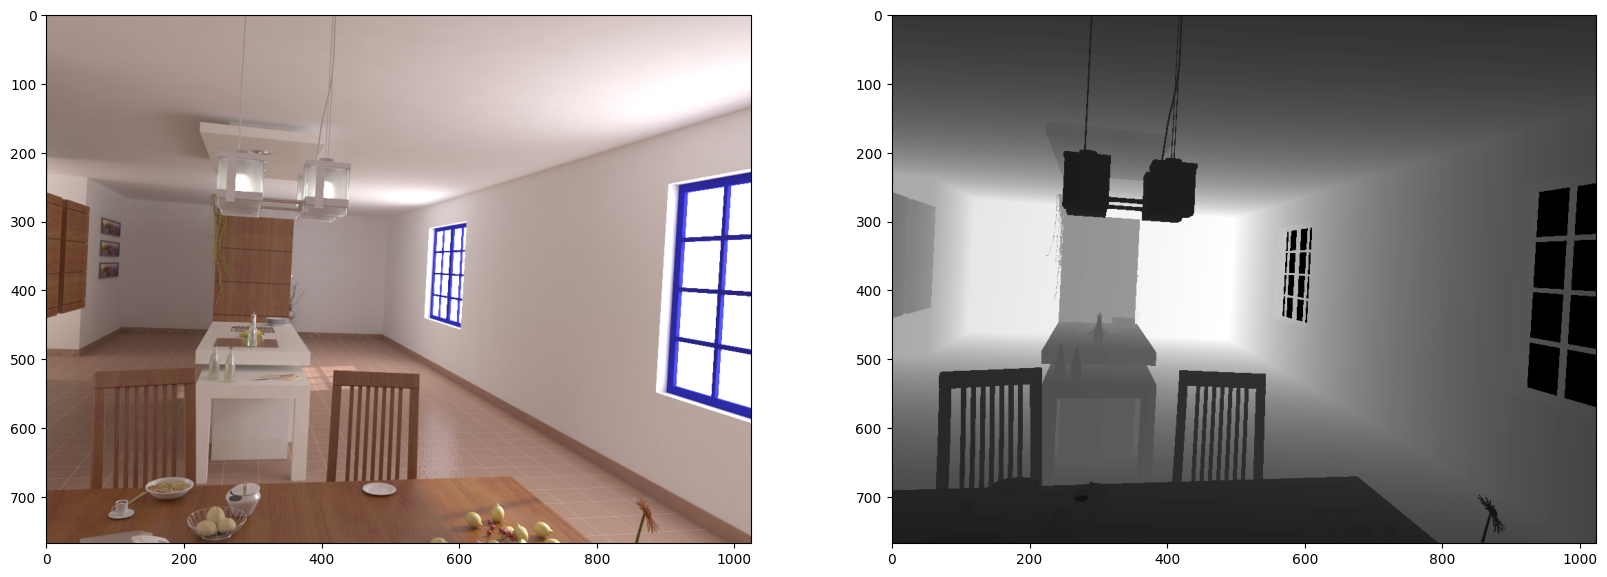

In [180]:
randind = np.random.randint(0, len(df_train))
print(f"Index: {randind}")
row = df_train.iloc[3586]
print(row)
dict_rgbd = return_dict_rgbd(row)
rgb = dict_rgbd["rgb"]
depth = dict_rgbd['depth']
valid = dict_rgbd['valid']

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(rgb)
plt.subplot(1,2,2)
plt.imshow(depth, cmap='gray')
# plt.subplot(2,2,3)
# plt.imshow(valid, cmap='gray')
# plt.subplot(2,2,4)
# plot_grayscale_histogram(depth)

print('---- Depth Report ----')
print()
print(f"Unique values: {np.unique(depth)}")
print(f"how many uniques: {len(np.unique(depth))}")
print(f"Max: {np.nanmax(depth)}")
print(f"Min: {np.nanmin(depth)}")
print(f"shape: {depth.shape}")
print(f"Has nan: {np.isnan(depth).any()}")
print(f"Dtype: {depth.dtype}")

---- Depth Report ----

Unique values: [ 0  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
how many uniques: 48
Max: 49
Min: 0
shape: (768, 1024, 3)
Has nan: False
Dtype: uint8


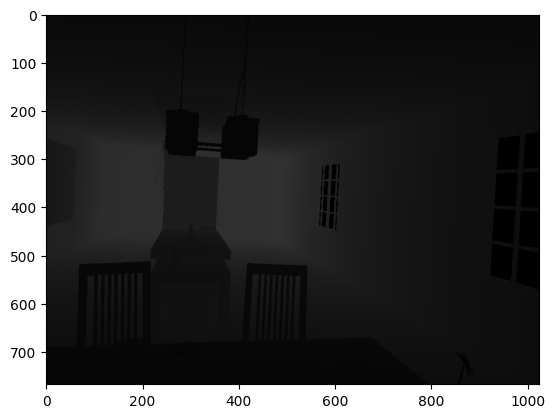

In [175]:
#testando o save

depth_test = cv2.imread('depth_test.png')


print('---- Depth Report ----')
print()
print(f"Unique values: {np.unique(depth_test)}")
print(f"how many uniques: {len(np.unique(depth_test))}")
print(f"Max: {np.nanmax(depth_test)}")
print(f"Min: {np.nanmin(depth_test)}")
print(f"shape: {depth_test.shape}")
print(f"Has nan: {np.isnan(depth_test).any()}")
print(f"Dtype: {depth_test.dtype}")

plt.imshow(depth_test)
plt.show()

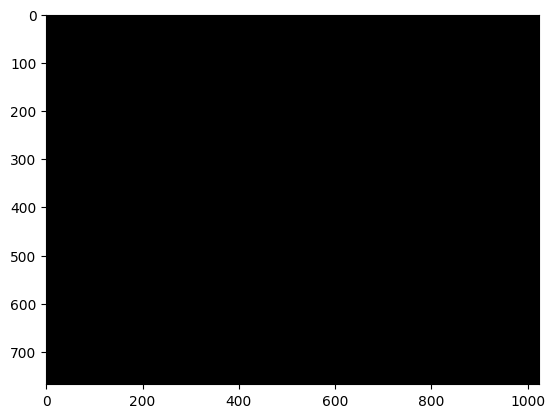

In [121]:
nan_mask = np.isnan(depth)*1
plt.imshow(nan_mask, cmap='gray')
plt.show()

Quando tiver NaN nos unique values, usar o penultimo valor dos uniques, quando não tiver, usar o ultimo valor dos uniques

Unique values: [0.32219586 0.32233371 0.32234276 ... 0.999601   1.         1.00006995]
how many uniques: 777964
Max: 1.0000699527184997
Min: 0.3221958649641345
Shape: (768, 1024)


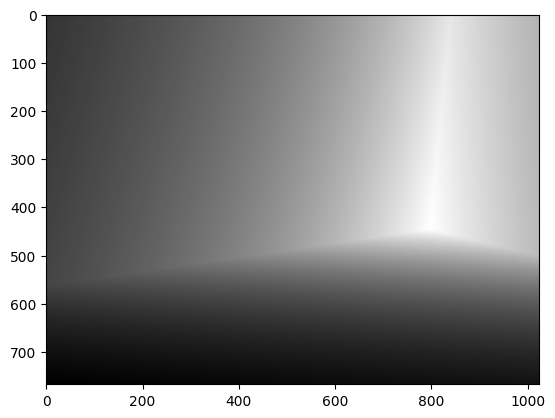

In [118]:
# pos tratamento de nan (esse tratamento ta ruim)
unique_values = np.unique(depth)
unique_values = unique_values[:-1]
max_local = np.max(unique_values)
depth_arr = np.nan_to_num(depth, copy=False, nan=max_local)
norm_depth = depth_arr/max_local

print(f"Unique values: {np.unique(norm_depth)}")
print(f"how many uniques: {len(np.unique(norm_depth))}")
print(f"Max: {np.max(norm_depth)}")
print(f"Min: {np.min(norm_depth)}")
print(f"Shape: {norm_depth.shape}")

plt.imshow(norm_depth, cmap='gray')
plt.show()

## transform float16 to uint8 to save

In [102]:
row = df_train.iloc[13469]
depth_arr = return_depth_arr(row)
print(row)

scene_name                    ai_012_007
camera_name                       cam_01
frame_id                               0
included_in_public_release          True
exclude_reason                       NaN
split_partition_name               train
Name: 18300, dtype: object


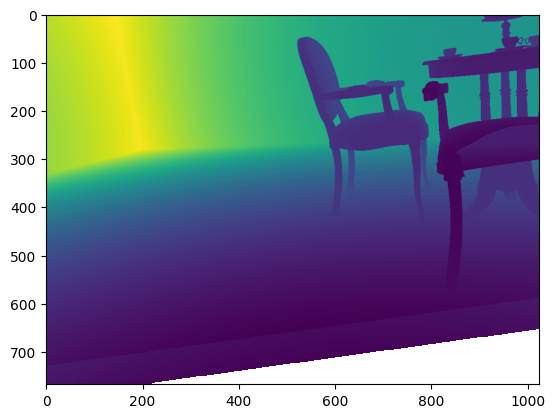

In [97]:
plt.imshow(depth_arr)

### nan mask

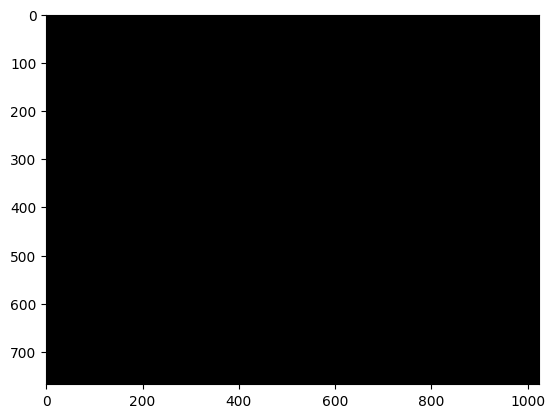

In [77]:
nan_mask = np.isnan(depth_arr)*1
plt.imshow(nan_mask, cmap='gray')

## function to save img as uint8 png

In [70]:
intWidth = 1024
intHeight = 768
fltFocal = 886.81
npyImageplaneX = np.linspace((-0.5 * intWidth) + 0.5, (0.5 * intWidth) - 0.5, intWidth).reshape(1, intWidth).repeat(intHeight, 0).astype(np.float32)[:, :, None]
npyImageplaneY = np.linspace((-0.5 * intHeight) + 0.5, (0.5 * intHeight) - 0.5, intHeight).reshape(intHeight, 1).repeat(intWidth, 1).astype(np.float32)[:, :, None]
npyImageplaneZ = np.full([intHeight, intWidth, 1], fltFocal, np.float32)
npyImageplane = np.concatenate([npyImageplaneX, npyImageplaneY, npyImageplaneZ], 2)

In [24]:
teste = [0 , 1 , 2, np.nan]

In [ ]:
# test to save uint8

row = df_train.iloc[13469]
depth_arr = return_depth_arr(row)
row

In [71]:
def save_uint8(row
               ):
    
    scene_name = row.scene_name
    camera_name = row.camera_name
    frame_id = str(row.frame_id).zfill(4) # format frame_id to four digits padding 0 (e.g. 2 -> 0002)
    
    depth_path = f"{base_path}/{scene_name}/images/scene_{camera_name}_geometry_hdf5/frame.{frame_id}.depth_meters.hdf5"
    
    dst_path = f"{save_path}/{scene_name}-{camera_name}-{frame_id}-depth.png" 
    
    depth_h5 = h5py.File(depth_path, "r")

    depth = depth_h5["dataset"]

    depth_arr = np.array(depth[:,:])



    # transform distance to depth

    fltFocal = 886.81
    npyDepth = depth_arr / np.linalg.norm(npyImageplane, 2, 2) * fltFocal

    has_nan = np.isnan(depth_arr).any()

    unique_values = np.unique(npyDepth)

    if has_nan: #se tiver nan -> 
        max_local = unique_values[-2] # pega o penultimo valor, pois o ultimo é nan
        depth_arr = np.nan_to_num(npyDepth, copy=False, nan=max_local) 
        norm_depth = depth_arr/max_local  
    else: # se nao tiver nan
        max_local = unique_values[-1] # pega o ultimo valor, que representa o maximo
        norm_depth = npyDepth/max_local

    norm_depth = npyDepth/max_local
    norm_depth = (norm_depth*255).astype(np.uint8)

    cv2.imwrite(dst_path, norm_depth)


    return None
    

In [72]:
# uncomment if needs to copy data again
#df_train.apply(save_uint8, axis=1)

## Testando as imagens do dataset preprocessado

---- Depth Report ----

Unique values: [  3   4   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95 228]
how many uniques: 92
Max: 228
Min: 3
shape: (768, 1024)
Has nan: False
Dtype: uint8


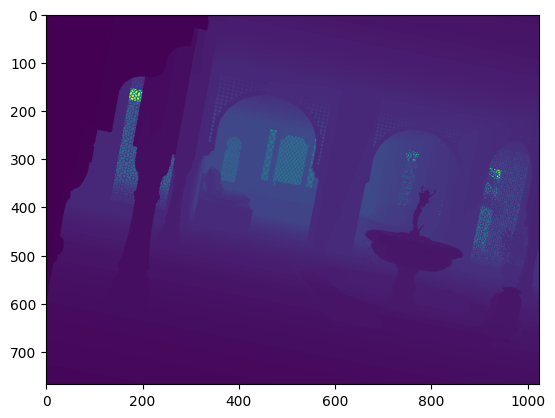

In [203]:
depth_path = '/home/gustavo/workstation/depth_inpainting/data/hypersim_preprocessed/test/depth/depth_ai_031_008_cam_00_fr0016.png'

depth = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)

print('---- Depth Report ----')
print()
print(f"Unique values: {np.unique(depth)}")
print(f"how many uniques: {len(np.unique(depth))}")
print(f"Max: {np.nanmax(depth)}")
print(f"Min: {np.nanmin(depth)}")
print(f"shape: {depth.shape}")
print(f"Has nan: {np.isnan(depth).any()}")
print(f"Dtype: {depth.dtype}")

plt.figure()
plt.imshow(depth)
plt.show()